# Euro area Real GDP and its Composition by Industry
In this notebook I look at the Real GDP of the Euro area and its composition by industry group. I look at the trends with respect to the Real GDP overall as well as in its consituent industries.

**NB**: It's easy to adjust the rest of this notebook to do analysis for a given EU country of choice or a particular subset of the EU. By default analysis is done for the Euro Area&mdash;geo code `EA`. Required adjustments can be done in Cell 3 below.

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail
# Install the latest version of eurostat
# !pip install eurostat -U

In [2]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from datetime import date
import math

import eurostat

In [3]:
geo_area = 'EA'
geo_label = 'Eurozone'

# geo_area = 'NL'
# geo_label = 'NL'

# Other possible values to the geo_area code can be obtained with:
# eurostat.get_par_values('namq_10_a10', 'geo')

In [4]:
report_start = date.fromisoformat('1996-01-01')
report_end = date.today()

In [5]:
# Querying for non seasonally adjusted all-items Eurozone GDP data in chained linked volumes of 2010
real_gdp = eurostat.get_data_df('namq_10_gdp', filter_pars={
    'startPeriod': report_start, 'unit': 'CLV10_MEUR', 's_adj': 'NSA', 'na_item': 'B1GQ', 'geo': geo_area}).iloc[:, 4:]
real_gdp = real_gdp.set_index(real_gdp.columns[0]).T
real_gdp = real_gdp.set_axis(pd.DatetimeIndex(real_gdp.index, 'QS'))

# To calculate the annual rate of GDP growth I sum up the non-seasonally adjusted GDP over the last 4 quarters.
# If Eurostat were publishing seasonally adjusted GDP data at annual volumes (as is the case in the US),
# I could calculate the mean over the past 4 quarters and use it as the actual annual GDP. 
real_gdp = real_gdp.rolling(4).sum().pct_change(4, fill_method=None).dropna()
real_gdp.rename(columns={'EA': 'Real GDP'}, inplace=True)
real_gdp.columns.names = [None]

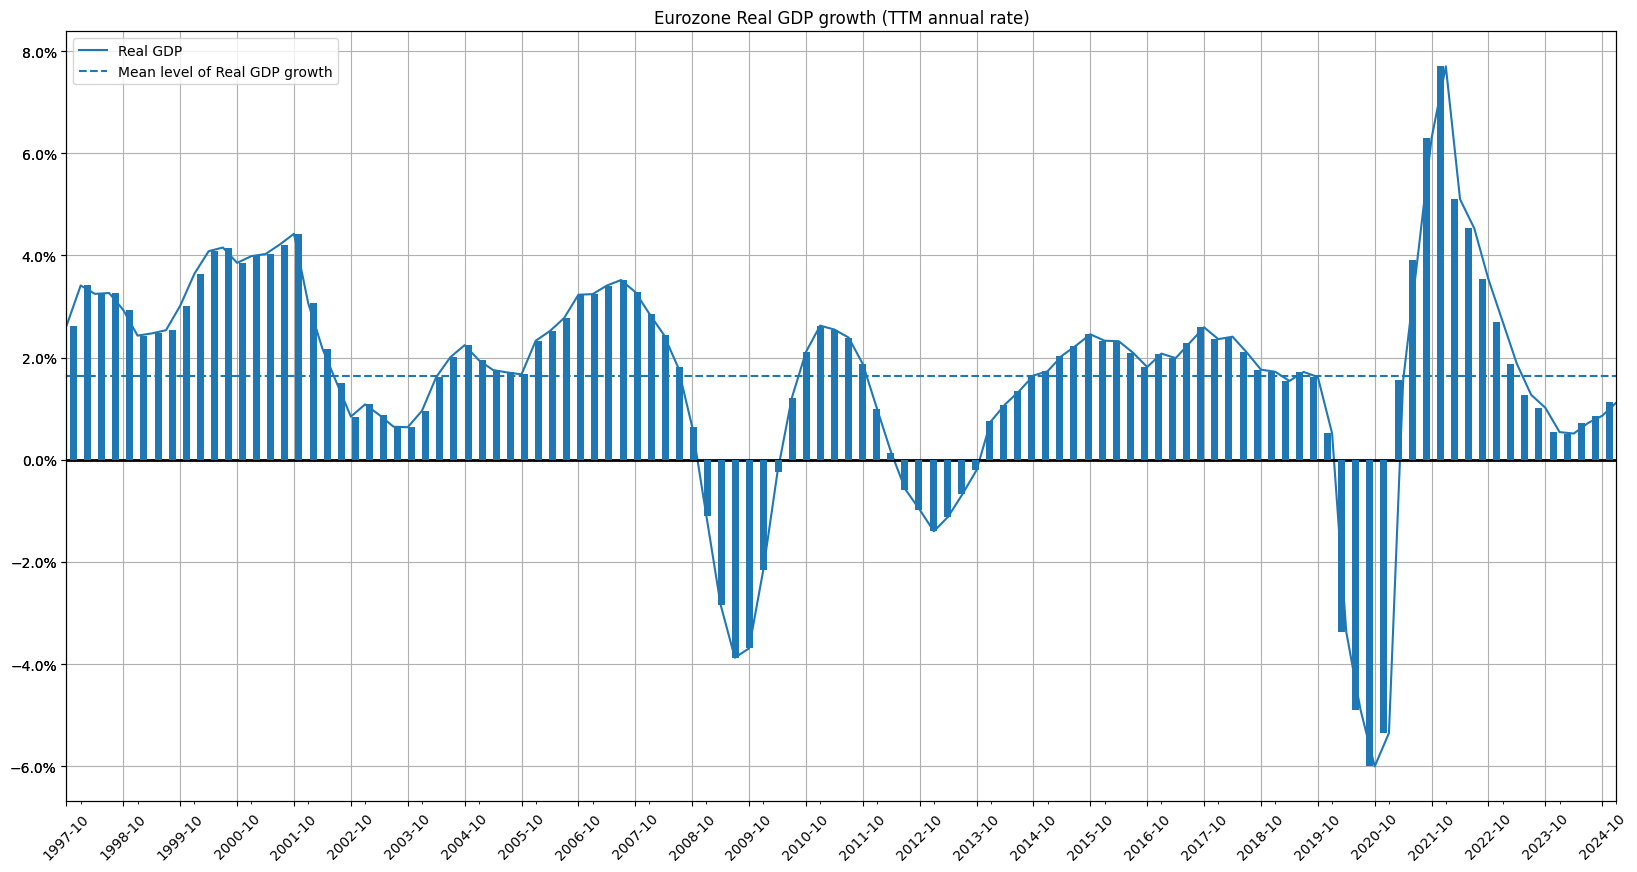

In [6]:
ax = real_gdp.iloc[:,0].plot(figsize=(20,10), grid=True, title=f'{geo_label} Real GDP growth (TTM annual rate)',
                   xticks=real_gdp.index[::4], xlabel='', rot=45)#, yticks=np.arange(-.15, .2, 0.025))
ax.axhline(y=0, lw=2, c='k')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2 = ax.twiny()
real_gdp.iloc[:,0].plot.bar(ax=ax2, xlabel='', legend=False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=real_gdp.iloc[:,0].mean(), ls='--', c='#1f77b4', label='Mean level of Real GDP growth')
ax.legend()
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, real_gdp.index[::4])))

In [7]:
print(f'Mean level of annual rate of real GDP growth in {geo_label} since {real_gdp.index[0]:%Y-%m-%d}: '
      f'{real_gdp.iloc[:,0].mean():.2%}')

Mean level of annual rate of real GDP growth in Eurozone since 1997-10-01: 1.64%


## Composition of Euro Area GDP
In this section of the notebook I look at the real value added (represents the sum of the costs-incurred and the incomes-earned in production, and consists of compensation of employees, taxes on production and imports, less subsidies, and gross operating surplus) for each constituent industry of Euro Area GDP and how it changed over the past 5 and 10 years as well as year to date. In other words I break down real GDP growth over a given timeframe into growth of individual industries.

I use chained linked volumes (2010) expressed in millions of euros as the unit of real measure of GDP and seasonally and calendar adjusted series. This is more appropriate as Eurostat publishes quarterly GDP data using quarterly rather than annual rates.

In [8]:
def get_gdp_components(s_adjustment=True, geo_area = 'EA'):
    gdp_components = eurostat.get_data_df('namq_10_a10', filter_pars={
        'startPeriod': report_start, 'unit': 'CLV10_MEUR', 's_adj': 'SCA' if s_adjustment else 'NSA',
        'nace_r2': ['A', 'B-E', 'C', 'F', 'G-I', 'J', 'K', 'L', 'M_N', 'O-Q', 'R-U', 'TOTAL'], 'geo': geo_area}).iloc[:, 5:]
    gdp_components = gdp_components.set_index(gdp_components.columns[0]).T
    gdp_components = gdp_components.set_axis(pd.DatetimeIndex(gdp_components.index, 'QS')).dropna()
    gdp_components.columns.names = [None]
    gdp_components.columns = ['Agriculture, forestry and fishing', 'Industry (except construction)', 'Manufacturing',
                              'Construction', 'Wholesale and retail trade, transport...',
                              'Information and communication', 'Financial and insurance activities',
                              'Real estate activities',
                              'Professional, scientific and technical activities...',
                              'Public administration, defence, education...',
                              'Arts, entertainment and recreation...', 'Total']
    return gdp_components

Eurostat uses [the NACE Rev.2 classification](https://eur-lex.europa.eu/LexUriServ/LexUriServ.do?uri=OJ:L:2010:210:0001:0021:EN:PDF) to define industry breakdowns. It publishes value added and income industry breakdowns only at the so-called `A*10` granularity, i.e. it breaks it down into 10 economic activities. Each of these has a unique `nace_r2` code:
1. Agriculture, forestry and fishing
1. Industry (except construction), this is also known as industrial production: mining, manufacturing and utilities.
    1. Manufacturing. Designated with a nace_r2 code of `C`. Since manufacturing is included in Industrial production, it needs to be taken into account to avoid double-counting
1. Construction
1. Wholesale and retail trade, transport, accommodation and food service activities
1. Information and communication
1. Financial and insurance activities
1. Real estate activities
1. Professional, scientific and technical activities; administrative and support service activities
1. Public administration, defence, education, human health and social work activities
1. Arts, entertainment and recreation; other service activities; activities of household and extra-territorial organizations and bodies

For brevity's sake I use shortened names of the activities in the rest of this notebook for better display.

In [9]:
gdp_components = get_gdp_components(geo_area=geo_area)
gdp_total = gdp_components.iloc[:,-1]
gdp_components_a10 = gdp_components.iloc[:,[0,1,3,4,5,6,7,8,9,10]]
gdp_components = gdp_components.iloc[:,:-1]

In [10]:
GRAPH_TITLE_GDP_COMPONENTS = f'Composition of {geo_label} GDP By Value Added'
GRAPH_TITLE_GDP_COMPONENTS_PCT_CHG = f'Percentage Change in Value Added by Each Component of {geo_label} GDP'

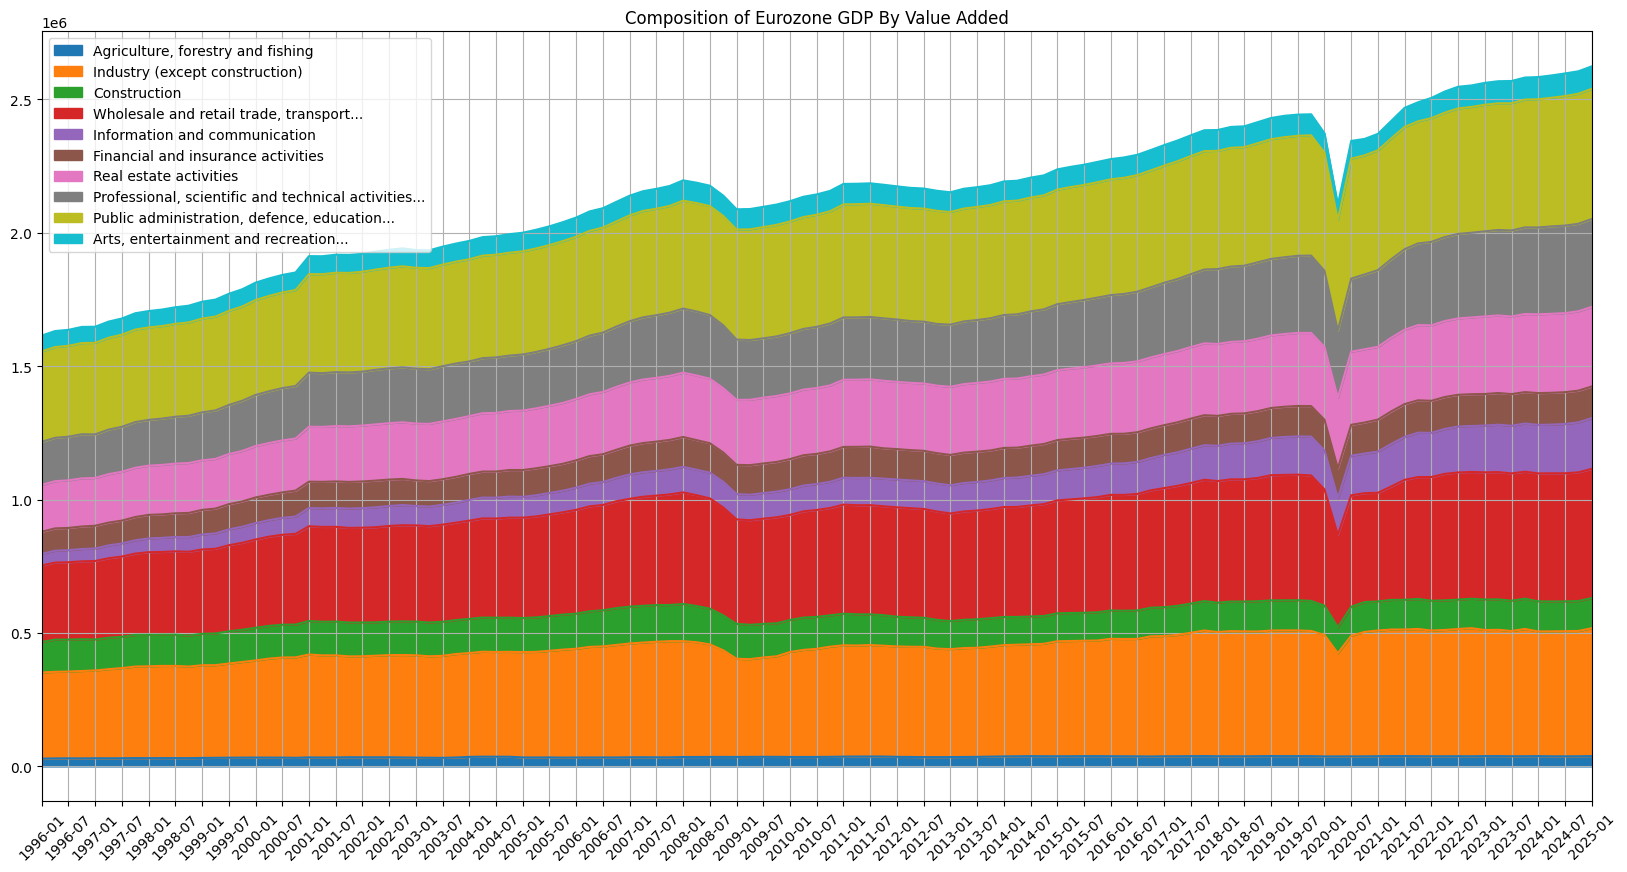

In [11]:
ax = gdp_components_a10.plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_GDP_COMPONENTS,
                                 xticks=gdp_components_a10.index[::2], xlabel='', rot=45)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, gdp_components_a10.index[::2])))

In [12]:
# Converting to percentages by dividing by total
gdp_components_pct = gdp_components_a10.divide(gdp_components_a10.sum(axis=1), axis=0)

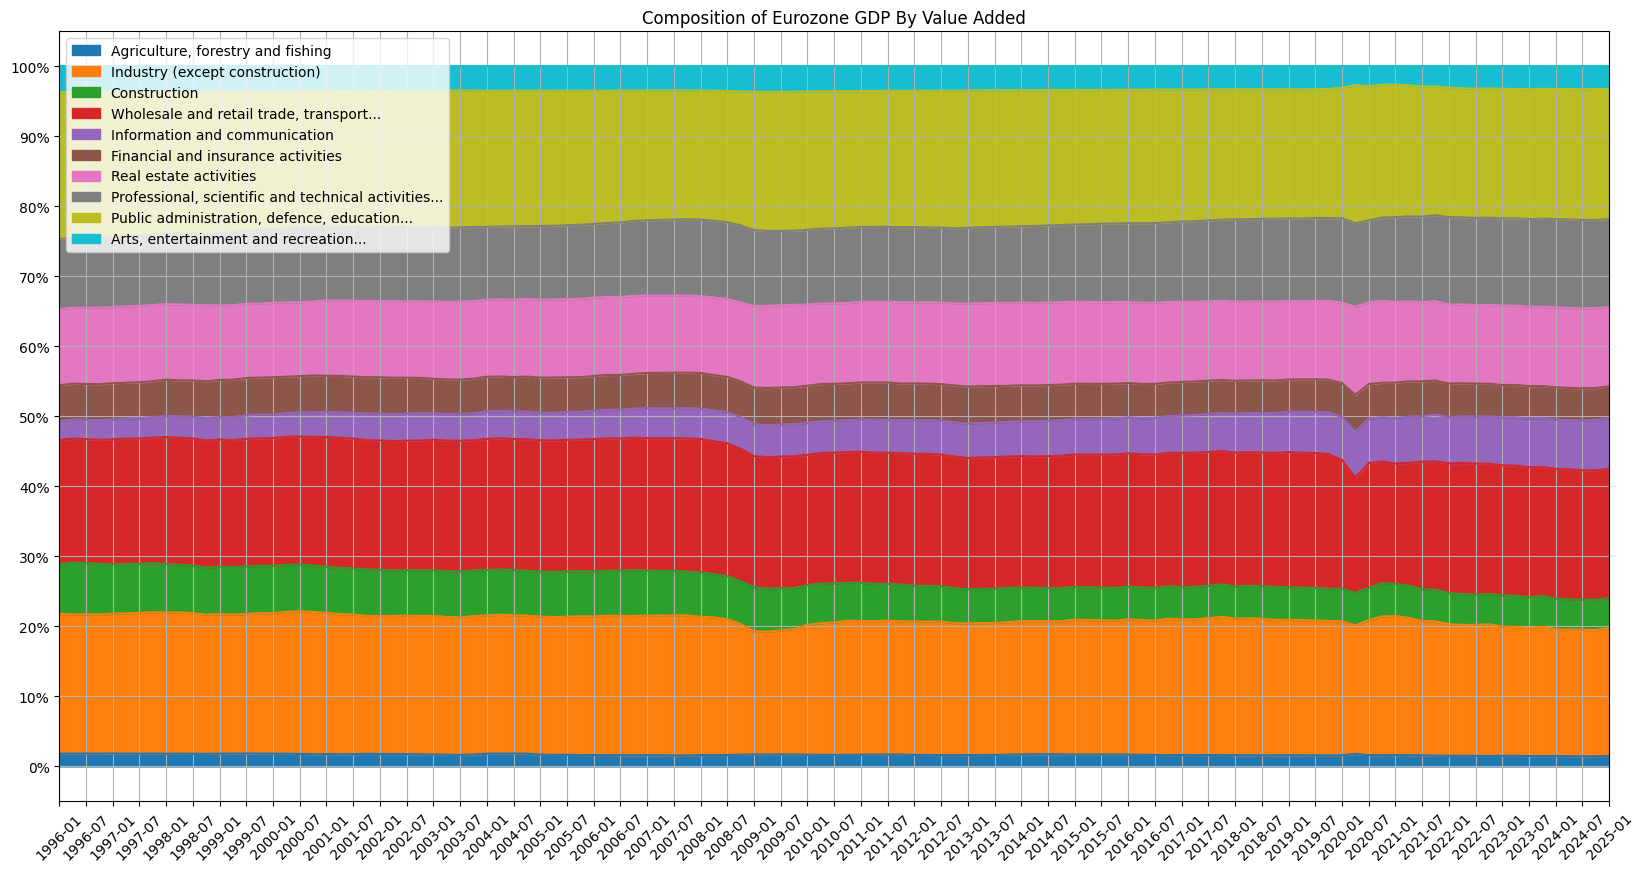

In [13]:
ax = gdp_components_pct.plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_GDP_COMPONENTS,
                                  xticks=gdp_components_pct.index[::2], xlabel='', rot=45,
                                  yticks=np.arange(0, 1.01, .1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.legend(loc='upper left')
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, gdp_components_pct.index[::2])))

In [14]:
pd.options.display.float_format = '{:.2%}'.format
gdp_components_pct.iloc[-1,:].sort_values(ascending=False)

Public administration, defence, education...           18.60%
Wholesale and retail trade, transport...               18.46%
Industry (except construction)                         18.26%
Professional, scientific and technical activities...   12.55%
Real estate activities                                 11.37%
Information and communication                           7.24%
Financial and insurance activities                      4.53%
Construction                                            4.31%
Arts, entertainment and recreation...                   3.21%
Agriculture, forestry and fishing                       1.47%
Name: 2025-01-01 00:00:00, dtype: float64

**Conclusion 1**:

The 
* Public administration, defence, education, human health and social work activities
* Wholesale and retail trade, transport, accommodation and food service activities
* Industrial production
* Professional, scientific and technical activities; administrative and support service activities
* Real estate activities

industries contributed the most (>10%) value added to Eurozone GDP as of the most recent quarter.

Now let's see what percentage of total GDP output is attributable to the `Manufacturing` industry group. As I explained earlier, it's part of a wider `Industry` category.

In [15]:
gdp_components.divide(gdp_components_a10.sum(axis=1), axis=0).iloc[-1,2:3]

Manufacturing   16.26%
Name: 2025-01-01 00:00:00, dtype: float64

### Percentage Changes in Value Added by Each Industry of Euro Area GDP
It's interesting to analyze how much each industry contributed to the overall Real GDP growth over a number of years. This lets us see which industries are growing the most. I compare cumulative GDP growth over the last 4 quarters (which gives annual growth) with that 5 and 10 years ago. This is more accurate than comparing the output in a given quarter with that same quarter 5 and 10 years ago.

The way I break down overall Real GDP percentage change over a period into those of indivudual industries so that they all sum up to the same number is by using the following formula. If X = Y + Z, then:

 percentage change of $X = {X_2 - X_1 \over X_1} = {Y_2 + Z_2 - Y_1 - Z_1 \over Y_1 + Z_1} = {Y_2 - Y_1  \over Y_1 + Z_1} + {Z_2 - Z_1 \over Y_1 + Z_1}$

I will limit analysis to changes over 5 and 10 years. If you want to analyze different intervals, just edit the `periods` variable in the below cell.

In [16]:
periods = [10, 5]

For this analysis it's better to switch to not seasonally adjusted data.

In [17]:
gdp_components = get_gdp_components(False, geo_area=geo_area)
gdp_total = gdp_components.iloc[:,-1]
gdp_components_a10 = gdp_components.iloc[:,[0,1,3,4,5,6,7,8,9,10]]
gdp_components = gdp_components.iloc[:,:-1]

First let's see by how much the total Real GDP has changed over the specified periods in percentage points.

In [18]:
gdp_total_pct_chg = pd.DataFrame([gdp_total.rolling(4).sum().pct_change(4*period).iloc[-1] for period in periods], 
                                 index=['Over past {:d} years'.format(period) for period in periods],
                                 columns=['Percentage Change'])
gdp_total_pct_chg

,Percentage Change
Over past 10 years,17.14%
Over past 5 years,7.03%


Now I break down these overall Real GDP percentage changes into percentage changes in individual industries so that they sum up to the same real GDP percentage change number.

In [19]:
gdp_components_pct_chg = pd.concat(
    [((gdp_components_a10.rolling(4).sum() - gdp_components_a10.rolling(4).sum().shift(4*period)).divide(
        gdp_total.rolling(4).sum().shift(4*period), axis=0)).iloc[-1] for period in periods], axis=1)
gdp_components_pct_chg.columns = ['Over past {:d} years'.format(period) for period in periods]

In [20]:
gdp_components_pct_chg.sort_values(by=gdp_components_pct_chg.columns[0], inplace=True)

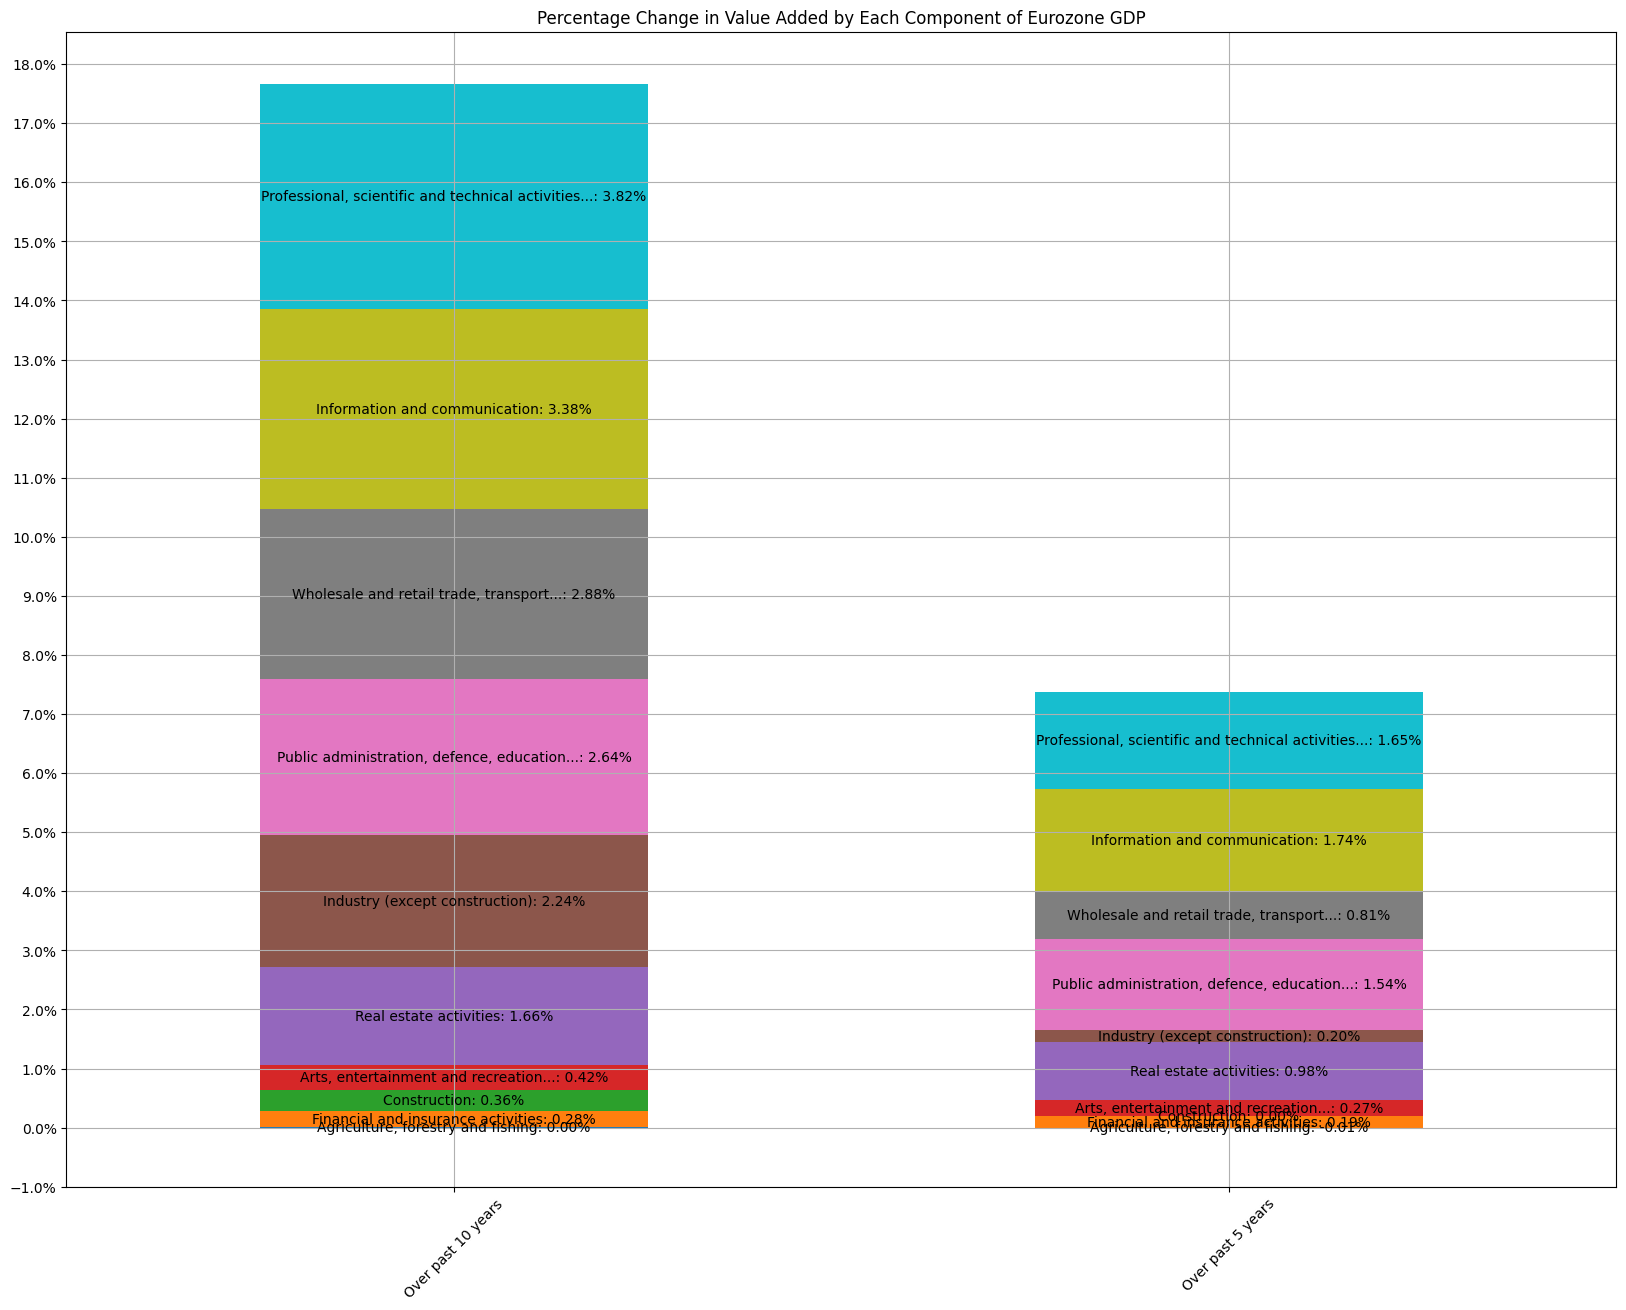

In [21]:
y_max = round(max([series[series.iloc[:] > 0].sum() for _, series in gdp_components_pct_chg.items()]) + .005, 2) + 1e-3
ax = gdp_components_pct_chg.T.plot.bar(figsize=(20,15), grid=True, title=GRAPH_TITLE_GDP_COMPONENTS_PCT_CHG,
                                       stacked=True, rot=45, yticks=np.arange(-.01, y_max, .01))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.get_legend().remove()
for c in ax.containers:
    ax.bar_label(c, fmt=c.get_label() + ': {:.2%}', label_type='center')

Due to the presence of GDP components not allocated to any particular industry and rounding errors, in Eurostat's `namq_10_a10` series the sum of the output of individual industries doesn't exactly sum up up to the total. There's an approximately 5% difference. The below cell checks that the discrepancy is not bigger than 5%.

In [22]:
assert np.allclose(gdp_components_pct_chg.sum(), gdp_total_pct_chg.squeeze(), rtol=.06)

**Conclusion 2**: The largest growing industries over the past 5 years, as measured by their real value added contributon to the overall GDP growth, are:
* Information and communication
* Professional, scientific and technical activities; administrative and support service activities
* Public administration, defence, education, human health and social work activities
* Real Estate

Of these industries:
* Professional, scientific and technical activities; administrative and support service activities
* Public administration, defence, education, human health and social work activities
* Real Estate
are also in the Top-5 biggest contributoes to the Eurozone GDP (see Conclusion 1 above).

Let's compare the top-5 growing industries over the past 5 and 10 years.

In [23]:
gdp_components_pct_chg.sort_values(by=gdp_components_pct_chg.columns[0], ascending=False).iloc[:5,:1]

,Over past 10 years
"Professional, scientific and technical activities...",3.82%
Information and communication,3.38%
"Wholesale and retail trade, transport...",2.88%
"Public administration, defence, education...",2.64%
Industry (except construction),2.24%


In [24]:
gdp_components_pct_chg.sort_values(by=gdp_components_pct_chg.columns[1], ascending=False).iloc[:5,1:]

,Over past 5 years
Information and communication,1.74%
"Professional, scientific and technical activities...",1.65%
"Public administration, defence, education...",1.54%
Real estate activities,0.98%
"Wholesale and retail trade, transport...",0.81%


**Conclusion 3**: Over the past 5 years `Real estate activities` industry groups supplanted `Industry (except construction)` and `Industrial production` in the list of the top-5 largest contributors to Eurozone GDP growth.

### Percentage Changes in Value Added by Each Industry of Euro Area GDP YTD

In [25]:
# Measuring growth YTD with the corresponding intervals in previous years.
month = gdp_components.index[-1].month
gdp_total_ytd = gdp_total.loc[gdp_total.index.month <= month]
gdp_total_ytd = gdp_total_ytd.resample('YS-JAN').sum().pct_change()

In [26]:
print(f'YTD GDP grew by {gdp_total_ytd.iloc[-1]:.2%}')

YTD GDP grew by 1.16%


In [27]:
qtd = math.ceil(gdp_components.index[-1].month / 3)

The following industries contributed below-stated percentage points to this growth:

In [28]:
gdp_components_pct_chg_ytd =\
    ((gdp_components.rolling(qtd).sum() - gdp_components.rolling(qtd).sum().shift(4)).divide(
        gdp_total.rolling(qtd).sum().shift(4), axis=0)).iloc[-1]
gdp_components_pct_chg_ytd.name = 'YTD to previous year'
gdp_components_pct_chg_a10_ytd = gdp_components_pct_chg_ytd.iloc[[0,1,3,4,5,6,7,8,9,10]].sort_values()
gdp_components_pct_chg_a10_ytd

Financial and insurance activities                     -0.02%
Construction                                           -0.01%
Agriculture, forestry and fishing                       0.01%
Arts, entertainment and recreation...                   0.03%
Wholesale and retail trade, transport...                0.09%
Real estate activities                                  0.11%
Professional, scientific and technical activities...    0.12%
Public administration, defence, education...            0.30%
Industry (except construction)                          0.32%
Information and communication                           0.32%
Name: YTD to previous year, dtype: float64

`Manufacturing`, which is a constututent of `Industry`, contributed the following percentage to GDP growth YTD:

In [29]:
gdp_components_pct_chg_ytd.iloc[2:3]

Manufacturing   0.45%
Name: YTD to previous year, dtype: float64

In [30]:
gdp_components_pct_chg_a10_ytd = pd.concat([gdp_components_pct_chg_a10_ytd,
                                           pd.Series([gdp_total_ytd.iloc[-1] - gdp_components_pct_chg_a10_ytd.sum()], ['Not Allocated'])])
df = gdp_components_pct_chg_a10_ytd.to_frame()
# Calculating the running totals
df['Running_Total'] = df.iloc[:, 0].cumsum()
df['Shifted_Total'] = df.loc[:, 'Running_Total'].shift(1).fillna(0)

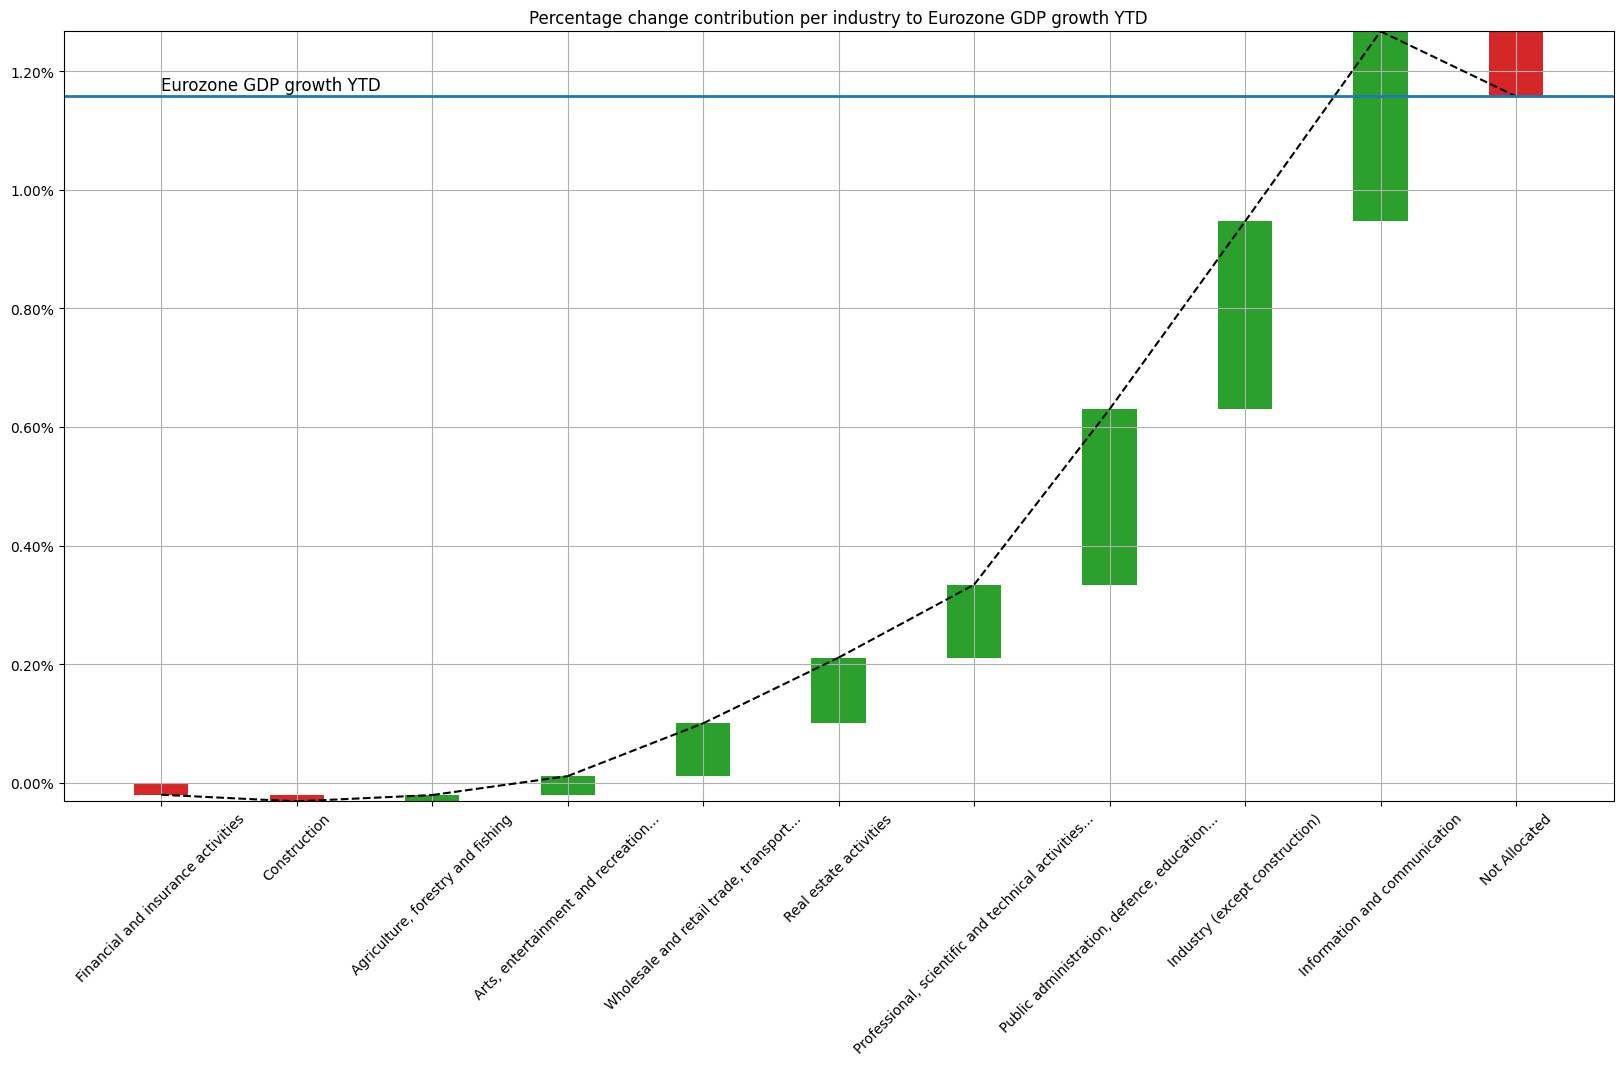

In [31]:
# plotting the waterfall chart
fig, ax = plt.subplots(figsize=(20, 10))

# code for Bars
ax.bar(df.index, df.iloc[:, 0], bottom=df.loc[:, 'Shifted_Total'], width=0.4,
       color=['#2ca02c' if x >= 0 else '#d62728' for x in df.iloc[:, 0]])

# code for lines to connect the bars
for i in range(1, len(df)):
    ax.plot([i-1, i], [df.iloc[i-1,1], df.iloc[i,1]], color='black', ls='--')

ax.set_xticks(df.index)
ax.set_xticklabels(df.index, rotation=45)
ax.grid(True)
ax.set_title(f'Percentage change contribution per industry to {geo_label} GDP growth YTD')
ax.axhline(y=gdp_total_ytd.iloc[-1], ls='-', lw=2, c='#1f77b4')
plt.text(0, gdp_total_ytd.iloc[-1]+.0001, f'{geo_label} GDP growth YTD', size='large')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()